<a href="https://colab.research.google.com/github/lkidane/Deep-Learning-Projects/blob/master/logistic_regression_teacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate gaussian data
===

Generate two balanced distributions with n poinds in dimension d

In [0]:
import torch


# dimension d and number of samples n
d = 2
n = 1000

# distribution parameters (two distributions, distribution 0 and distribution 1)
mu_0 = torch.zeros(n, d)
mu_1 = torch.zeros(n, d)
mu_1[:, 0] = 5
sigma = 1

# generate x with distribution 0 (corresponding to labels -1)
x_0 = torch.normal(0, 1, size=(n, d)) + mu_0
t_0 = - torch.ones(n)

# generate x with distribution 1 (corresponding to labels +1)
x_1 = torch.normal(0, 1, size=(n, d)) + mu_1
t_1 = torch.ones(n)

# stack them 
X = torch.cat((x_0, x_1), dim=0)
T = torch.cat((t_0, t_1), dim=0)

# generate y 
x_0.size(), x_1.size(), t_0.size(), t_1.size(), X.size(), T.size()

(torch.Size([1000, 2]),
 torch.Size([1000, 2]),
 torch.Size([1000]),
 torch.Size([1000]),
 torch.Size([2000, 2]),
 torch.Size([2000]))

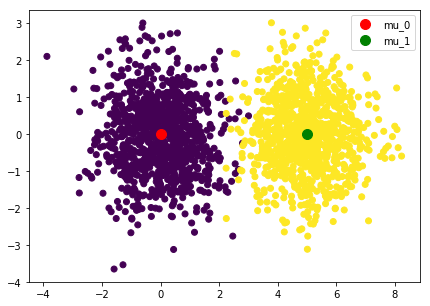

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], c=T)
plt.scatter([mu_0[0][0].item()], [mu_0[0][1].item()], c='red', s=100, label='mu_0')
plt.scatter([ mu_1[0][0].item()], [mu_1[0][1].item()], c='green', s=100, label='mu_1')
plt.legend()
plt.show()

Code loss function and its gradient
===

With formulas given in class

In [0]:
from scipy.special import expit


def loss_function(w, b, X, T):
    margin = T * (torch.mm(X, w).squeeze() - b)
    return torch.mean(torch.log(1 + torch.exp(-margin)))

def gradient(w, b, X, T):
    margin = T * (torch.mm(X, w).squeeze() - b)
    coef = expit(- margin)
    return -torch.mean((coef * T).reshape(-1, 1) * X, axis=0), -torch.mean(coef * T)

Gradcheck the gradient
====
We use finite difference approximations to check that
```loss_function(w + e_i*h, b, X, T) - loss_function(w - e_i*h, b, X, T)) / 2h```

is close to the gradient
```gradient(w, b, X, T)```
 __per coordinate__ (e_i is the basis vector for coordinate i).

In [0]:
import numpy as np

# generate random w and b parameters to test on them 
w = torch.rand(d, 1)
b = torch.rand(1)

# compute approximation of the gradient along coordinate i
def finite_differences(w, b, X, T, h, i):
    d = w.size(0)
    H = torch.zeros(d, 1)
    H[i] = h
    return (loss_function(w + H, b, X, T) - loss_function(w - H, b, X, T)) / (2 * h)

# gradcheck for given h for every coordinate
h = 1e-5
error = 0
for i in range(d):
    # we use double() for more precision during the gradcheck
    error += (finite_differences(w.double(), b.double(), X.double(), T, h, i) \
             - gradient(w.double(), b.double(), X.double(), T)[0][i])
print(error.item())

2.172410457079721e-08


Pytorch version
===
With nn.Modules

In [0]:
import torch.nn as nn


# define a linear layer (fully conected)
model = nn.Linear(d, 1)

# this is the logistic regression loss
loss = nn.BCEWithLogitsLoss()

# we recover the Y's that are in {0, 1} from the T's that are in {-1, 1}
Y = (T + 1) / 2

# define an optimizer that will do the gradient steps
sgd = torch.optim.SGD(model.parameters(), 1)

# training loop 
L = []
for step in range(2000):
    l_ = loss(model(X)[:,0], Y) # 1: forward
    L.append(l_.item())         # 1bis: save loss
    sgd.zero_grad()             # 2: zero grad so that the gradients are not accumulated
    l_.backward()               # 2: backward
    sgd.step()                  # 3: gradient step 

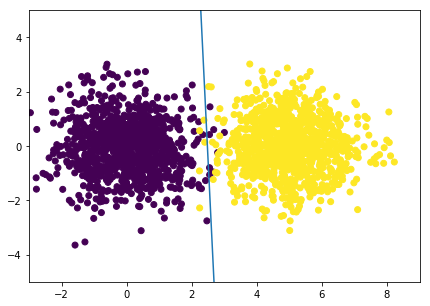

In [0]:
# how to recover the hyperplane from the model?
new_w = model.weight.data
new_b = model.bias.data
points = torch.linspace(-10, 10, 100)
hyperplane = -new_w[0, 0] / new_w[0, 1] * points - new_b / new_w[0, 1]

# plot the hyperplane and see that it does separate well the data
plt.figure(figsize=(7, 5))
plt.plot(points, hyperplane)
plt.xlim([-3, 9])
plt.ylim([-5, 5])
plt.scatter(X[:, 0], X[:, 1], c=T)
plt.show()

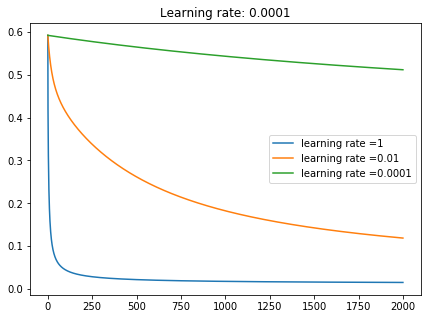

In [0]:
# plot the loss and see the influence of the learning rate 
model_base = nn.Linear(d, 1)
plt.figure(figsize=(7, 5))
for lr in [1, 0.01, 0.0001]:
    # define a linear layer (fully conected) that is initialized in the same way (model_base)
    model = nn.Linear(d, 1)
    model.load_state_dict(model_base.state_dict())
    
    # this is the logistic regression loss
    loss = nn.BCEWithLogitsLoss()

    # we recover the Y's that are in {0, 1} from the T's that are in {-1, 1}
    Y = (T + 1) / 2

    # define an optimizer that will do the gradient steps
    sgd = torch.optim.SGD(model.parameters(), lr)

    # training loop 
    L = []
    for step in range(2000):
        l_ = loss(model(X)[:,0], Y) # 1: forward
        L.append(l_.item())         # 1bis: save loss
        sgd.zero_grad()             # 2: zero grad so that the gradients are not accumulated
        l_.backward()               # 2: backward
        sgd.step()                  # 3: gradient step 


    
    plt.plot(L,label=f"learning rate ={lr}" )
plt.title('Learning rate: {:.4f}'.format(lr))
plt.legend()
plt.show()

Are PyTorch loss and gradient the same as the exact formulas?
===

In [0]:
# define a linear layer (fully conected)
model = nn.Linear(d, 1)

# this is the logistic regression loss
loss = nn.BCEWithLogitsLoss()

# we recover the Y's that are in {0, 1} from the T's that are in {-1, 1}
Y = (T + 1) / 2

model.zero_grad()
l_ = loss(model(X)[:,0], Y) 
l_.backward()      

In [0]:
# same losses, here we consider -b (see the definition in the slides)
l_.item(), loss_function(model.weight.data.t(), -model.bias.data, X, T).item()

(1.124692440032959, 1.1243326663970947)

In [0]:
# same gradients, here we consider -b (see the definition in the slides)
model.weight.grad, gradient(model.weight.data.t(), -model.bias.data, X, T)[0]

(tensor([[-1.8880,  0.1382]]), tensor([-1.8876,  0.1382]))

Train and Test sets
====

We consider a train set in which we learn the hyperplane, and a test set on which we test the learnt hyperplane. 

In [0]:
# dimension d and number of samples n
d = 2
n_train = 2
n_test = 1000

### Train set ###

# distribution parameters (two distributions, distribution 0 and distribution 1)
mu_0 = torch.zeros(n_train, d)
mu_1 = torch.zeros(n_train, d)
mu_1[:, 0] = 2
sigma = 0.2

# generate x with distribution 0 (corresponding to labels -1)
x_0 = torch.normal(0, 1, size=(n_train, d)) + mu_0
t_0 = - torch.ones(n_train)

# generate x with distribution 1 (corresponding to labels +1)
x_1 = torch.normal(0, 1, size=(n_train, d)) + mu_1
t_1 = torch.ones(n_train)

# stack them 
X_train = torch.cat((x_0, x_1), dim=0)
T_train = torch.cat((t_0, t_1), dim=0)

### Test set ###

# distribution parameters (two distributions, distribution 0 and distribution 1)
mu_0 = torch.zeros(n_test, d)
mu_1 = torch.zeros(n_test, d)
mu_1[:, 0] = 2
sigma = 0.2

# generate x with distribution 0 (corresponding to labels -1)
x_0 = torch.normal(0, 1, size=(n_test, d)) + mu_0
t_0 = - torch.ones(n_test)

# generate x with distribution 1 (corresponding to labels +1)
x_1 = torch.normal(0, 1, size=(n_test, d)) + mu_1
t_1 = torch.ones(n_test)

# stack them 
X_test = torch.cat((x_0, x_1), dim=0)
T_test = torch.cat((t_0, t_1), dim=0)

In [0]:
import torch.nn as nn


# define a linear layer (fully conected)
model = nn.Linear(d, 1)

# this is the logistic regression loss
loss = nn.BCEWithLogitsLoss()

# we recover the Y's that are in {0, 1} from the T's that are in {-1, 1}
Y_train = (T_train + 1) / 2

# define an optimizer that will do the gradient steps
sgd = torch.optim.SGD(model.parameters(), 1)

# training loop 
L = []
for step in range(2000):
    l_ = loss(model(X_train)[:,0], Y_train) # 1: forward
    L.append(l_.item())                     # 1bis: save loss
    sgd.zero_grad()                         # 2: zero grad so that the gradients are not accumulated
    l_.backward()                           # 2: backward
    sgd.step()                              # 3: gradient step 

The hyperplane is separating the train set reasonably well: it has a good training error

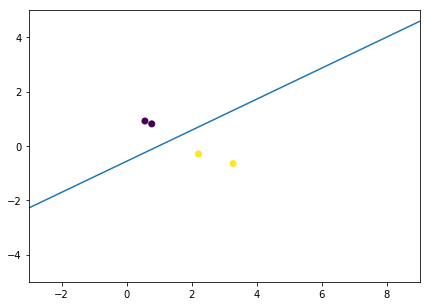

Training loss: 0.0008


In [0]:
# the hyperplane is separating the train set reasonably well: it has a good training error
new_w = model.weight.data
new_b = model.bias.data
points = torch.linspace(-10, 10, 100)
hyperplane = -new_w[0, 0] / new_w[0, 1] * points - new_b / new_w[0, 1]

# plot the hyperplane and see that it does separate well the data
plt.figure(figsize=(7, 5))
plt.plot(points, hyperplane)
plt.xlim([-3, 9])
plt.ylim([-5, 5])
plt.scatter(X_train[:, 0], X_train[:, 1], c=T_train)
plt.show()

# training loss
print('Training loss: {:.4f}'.format(loss(model(X_train)[:,0], Y_train)))

However, the hyperplane is not well suited for the test set on which is was not learnt. The test error or generalization error is worse.

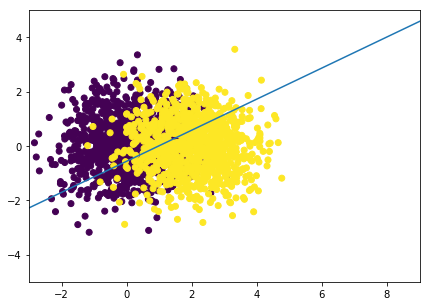

Test loss: 1.5288


In [0]:
# how to recover the hyperplane from the model?
new_w = model.weight.data
new_b = model.bias.data
points = torch.linspace(-10, 10, 100)
hyperplane = -new_w[0, 0] / new_w[0, 1] * points - new_b / new_w[0, 1]

# plot the hyperplane and see that it does separate well the data
plt.figure(figsize=(7, 5))
plt.plot(points, hyperplane)
plt.xlim([-3, 9])
plt.ylim([-5, 5])
plt.scatter(X_test[:, 0], X_test[:, 1], c=T_test)
plt.show()

# test loss
Y_test = (T_test + 1) / 2
print('Test loss: {:.4f}'.format(loss(model(X_test)[:,0], Y_test)))